<a href="https://www.kaggle.com/code/alaa2mahmoud/notebook22ee7b81cb?scriptVersionId=129494327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dog Breed Identification
___
**Description :** 
___
- You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset   comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. The list of breeds is as follows: 120 breed

___
**Files Descriptions :**
- `train.zip` - The training set, you are provided the breed for these dogs
- `test.zip` - The test set, you must predict the probability of each breed for each image
- `sample_submission.csv` - A sample submission file in the correct format
- `labels.csv` - The breeds for the images in the train set



## Importing , Preprocessing Data :
___
- `Read` Images
- `Resize` Images
- Convert Type to `tf.float32`
- Normalize by dividing on `255`
___

In [1]:
# Basic imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv 
import os
import tensorflow as tf
import tensorflow_hub as hub
import time
import datetime

In [2]:
os.chdir("/kaggle/input/dog-breed-identification")

In [3]:
labels = pd.read_csv("labels.csv")
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


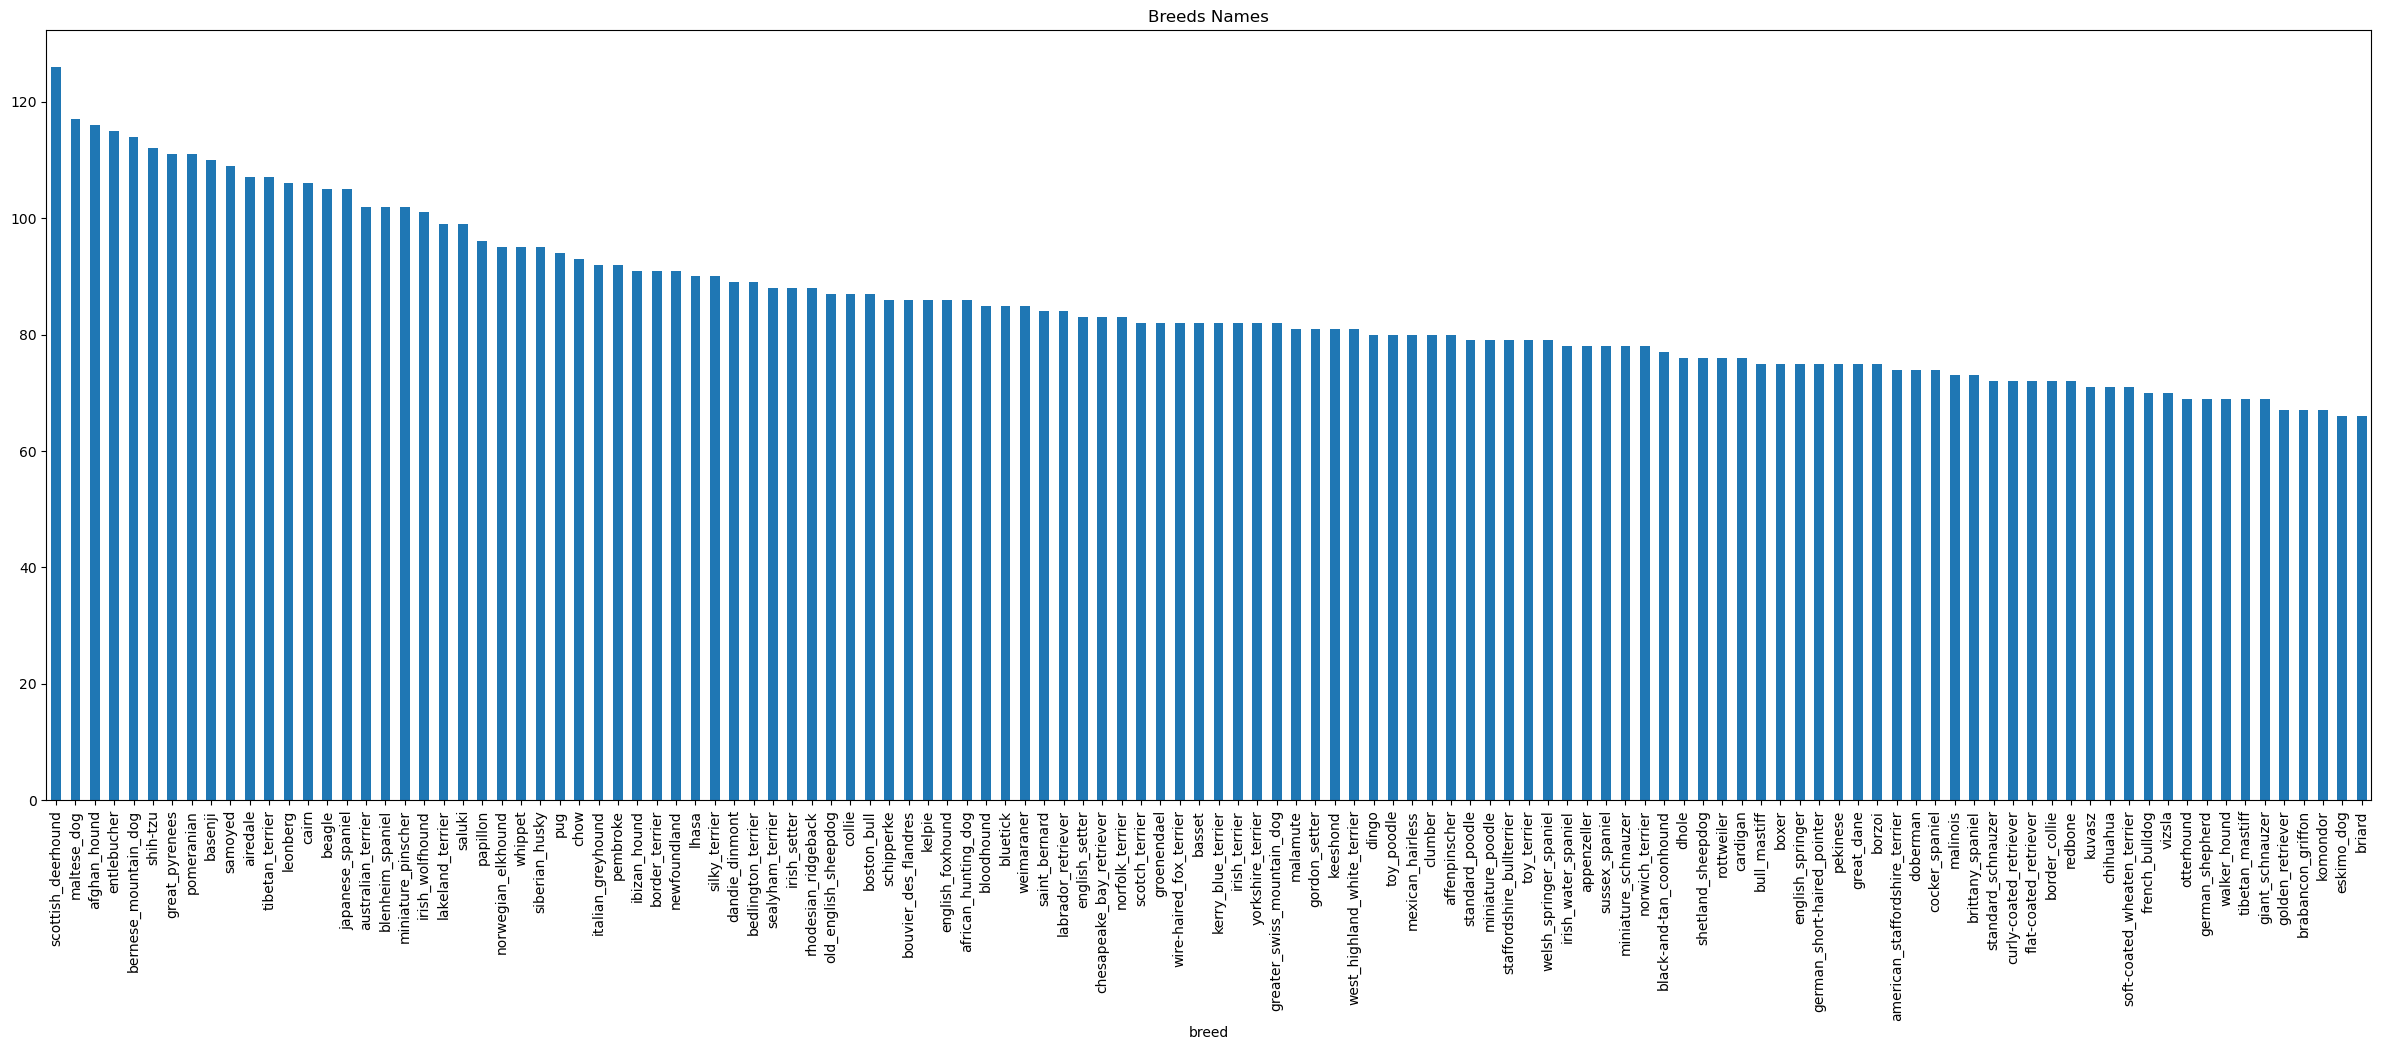

In [4]:
labels.breed.value_counts().plot(kind='bar',figsize=(30,10),title='Breeds Names');

In [5]:
IMG_SZ=224
bat=32

In [6]:
# read images in grey mode

train_paths = labels.id.map(lambda x:f"train//{x}.jpg")

# Minimize comp power 
# read images

imgs = labels.id.map(lambda x:tf.constant(cv.resize(cv.imread(f"train//{x}.jpg"),(IMG_SZ,IMG_SZ)),tf.float32)/255).to_list()
imgs = np.array(imgs)

gr_imgs = labels.id.map(lambda x:tf.constant(cv.resize(cv.imread(f"train//{x}.jpg",0),(IMG_SZ,IMG_SZ)),tf.float32)/255).to_list()
gr_imgs = np.array(gr_imgs)

Text(0.5, 1.0, 'bedlington_terrier')

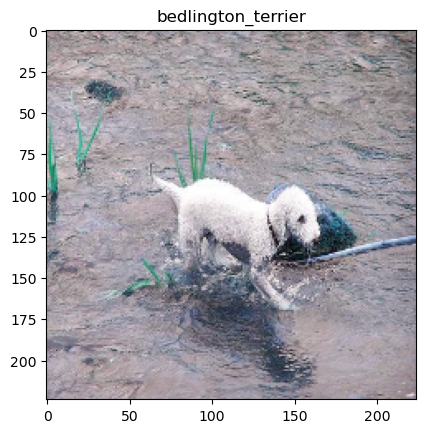

In [8]:
plt.imshow(imgs[5])
plt.title(labels.breed[5])

Text(0.5, 1.0, 'bedlington_terrier')

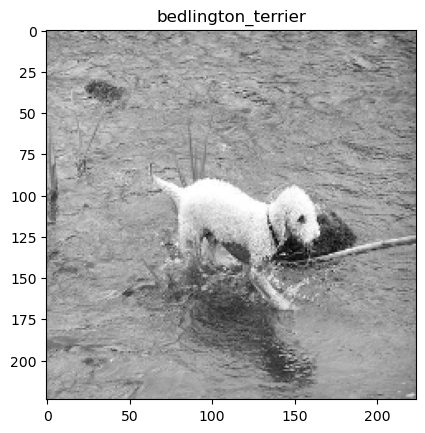

In [9]:
plt.imshow(gr_imgs[5],cmap='gray')
plt.title(labels.breed[5])

In [8]:
from sklearn.preprocessing import LabelEncoder



y_train=labels.breed

unique=labels.breed.unique()

y_train=np.array([list(map(lambda y : x==y , unique )) for x in y_train])

len(unique),y_train.shape

(120, (10222, 120))

In [9]:
y_train[20],labels.breed.unique()[y_train[20].argmax()],labels.breed[20]

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 'doberman',
 'doberman')

## Building Models
___
- MOBILENET_VS_130_224
    ____
- VGG:
    - `16`
    - `19`
    _____
- RESNET_V2:
    - `50`
    - `101`
    - `152`
    ____

In [23]:
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from keras.layers import Flatten, Dense, Input, MaxPooling2D, Dropout, GlobalMaxPool2D, Lambda, GlobalAveragePooling2D, BatchNormalization, Add
from keras.models import Model,load_model
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
from sklearn.metrics import classification_report

In [11]:
IN_SHP=imgs[0].shape
OUT_SHP=len(set(labels.breed))
np.random.seed(42)

In [12]:
## Create callbacks
%load_ext tensorboard

In [41]:
def evaluate(val=np.arange(5),mo=None,X=None,Y=None,uni=None):
    """
    Function to evaluate Model and plot custome plot contains :
    ____________________________________________________________
    - Image 
    - Horizontal bar plot of highest 5 predictions
    - Title show if it's True or False and the right breed
    ____________________________________________________________
    - mo  : The Model
    - X   : Features for predictions
    - Y   : True Labels " Predictions "
    - uni : Set of Breeds 
    """
    pre=mo.predict(X)
    for i in val:
        cols = np.array(['green','gray','gray','gray','gray'])
        resu=pd.DataFrame(data=(uni,pre[i].round(4)*100)).T.sort_values(by=[1],ascending=False)[:5]

        plt.figure(figsize=(20,5))
        ax_1=plt.subplot(1,2,1)
        ax_1.margins(2,2)
        ax_1.imshow(cv.cvtColor(imgs[i],cv.COLOR_BGR2RGB),cmap='gray')
        ax_2=plt.subplot(1,2,2)
        ax_2.margins(.5,.1)
        # ax_2.barh(resu[0],resu[1],color=['salmon','gray','k','k','k'])

        if pre[i].argmax()==Y[i].argmax():
            ax_2.barh(resu[0],resu[1],color = cols)
            plt.title(f"{uni[pre[i].argmax()]} By {np.round(pre[i][pre[i].argmax()]*100,2)}%",color='green')
        else:
            cols[0] = 'gray'
            cols[resu[0]==uni[Y[i].argmax()]] = 'green'
            ax_2.barh(resu[0],resu[1],color=cols)
            plt.title(f"{uni[pre[i].argmax()]} By {np.round(pre[i][pre[i].argmax()]*100,2)}% , True : {uni[Y[i].argmax()]}",color='red')
    return pre

### MOBILENET_VS_130_224
- `Try single pretrained model`

In [31]:
IN_SHP=imgs[0].shape
OUT_SHP=len(set(labels.breed))
MODEL_PATH = r"https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

i=Input(IN_SHP)

x=hub.KerasLayer(MODEL_PATH)(i)

x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Dense(1024,activation='relu')(x)

x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Dense(512,activation='relu')(x)

x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Dense(1024,activation='relu')(x)

x=Dense(OUT_SHP,activation='softmax')(x)

model=Model(i,x)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

model.summary()

Model: "model_6"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 keras_layer_7 (KerasLayer)  (None, 1001)              5432713   

                                                                 

 dropout_9 (Dropout)         (None, 1001)              0         

                                                                 

 batch_normalization_9 (Batc  (None, 1001)             4004      

 hNormalization)                                                 

                                                                 

 dense_24 (Dense)            (None, 1024)              1026048   

                                                                 

 dropout_10 (Dropout)        (None, 1024)              0         

                                           

In [26]:
def tb_call():
    loc=os.path.join("logs",
                     datetime.datetime.now().strftime("%Y-%m-%d -- %H-%M-%S"))
    return TensorBoard(loc)
tb_call_1=tb_call()
es_call=EarlyStopping("val_accuracy",verbose=1,patience=3)
mc_call=ModelCheckpoint(r"checkpoint\mobilenet_v2_130_224_best.h5",
                        monitor='val_accuracy', save_best_only=True, mode='max', verbose=2)

In [32]:
EP=50
BT_SZ=128

data_gen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,width_shift_range=0.1,height_shift_range=0.1)

x_tr,x_val,y_tr,y_val = train_test_split(imgs,y_train,test_size=0.1)

data=data_gen.flow(x_tr,y_tr,batch_size=BT_SZ)

# val_data=data_gen.flow(x_val,y_val,batch_size=BT_SZ)

model.fit(data,
          validation_data=(x_val,y_val),
          batch_size=BT_SZ,epochs=EP,
          callbacks=[es_call,mc_call])

Epoch 1/50

72/72 [==============================] - ETA: 0s - loss: 3.3264 - accuracy: 0.2264

Epoch 1: val_accuracy did not improve from 0.63734

72/72 [==============================] - 98s 1s/step - loss: 3.3264 - accuracy: 0.2264 - val_loss: 1.4361 - val_accuracy: 0.5709

Epoch 2/50

72/72 [==============================] - ETA: 0s - loss: 2.1341 - accuracy: 0.4281

Epoch 2: val_accuracy did not improve from 0.63734

72/72 [==============================] - 95s 1s/step - loss: 2.1341 - accuracy: 0.4281 - val_loss: 1.2640 - val_accuracy: 0.6256

Epoch 3/50

72/72 [==============================] - ETA: 0s - loss: 1.9165 - accuracy: 0.4780

Epoch 3: val_accuracy did not improve from 0.63734

72/72 [==============================] - 94s 1s/step - loss: 1.9165 - accuracy: 0.4780 - val_loss: 1.2820 - val_accuracy: 0.6315

Epoch 4/50

72/72 [==============================] - ETA: 0s - loss: 1.7993 - accuracy: 0.5003

Epoch 4: val_accuracy did not improve from 0.63734

72/72 [===========

In [38]:
model.evaluate(x_val,y_val)

32/32 [==============================] - 9s 275ms/step - loss: 1.1743 - accuracy: 0.6588


[1.1743091344833374, 0.6588465571403503]

### VGG19 + InceptionResNetV2 + Xception + NASNetLarge : 
___
- `Fearures Extraction`

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
def get_features(model, preprocessor, input_size, imgs):
    """
    Function to extract features from images using fine tunned models
    """

    x = Input(input_size)
    
    x = Lambda(preprocessor)(x)
    
    x = model(x)
    
    fe_mo = Model(inputs = input_layer, outputs = base_model)
    
    features = fe_mo.predict(imgs, verbose=1)
    print('Feature maps shape: ', features.shape)
    return features

In [33]:
# Load and use fine tuned models to extract features

# MobileNet
mb_fein = tf.keras.applications.mobilenet_v3.preprocess_input
mb_clf = load_model(r"checkpoint\mobilenet_v2_130_224_best.h5",custom_objects={'KerasLayer':hub.KerasLayer})
mb_fe = get_features(mb_clf,mb_fein, IN_SHP, imgs)

# ResNet
res_fein = tf.keras.applications.resnet_v2.preprocess_input
res_clf = load_model(r"checkpoint\RESNET152v2.h5")
res_fe = get_features(res_clf, res_fein, IN_SHP, imgs)

# Xception
xc_fein = tf.keras.applications.xception.preprocess_input
xc_clf = load_model(r"checkpoint\xception.h5")
xc_fe = get_features(xc_clf, xc_fein, IN_SHP, imgs)

# NASNET
nan_fein = tf.keras.applications.nasnet.preprocess_input
nan_clf = load_model(r"checkpoint\NASNET.h5")
nan_fe = get_features(nan_clf, nan_fein, IN_SHP, imgs)

# VGG
vg_fein = tf.keras.applications.vgg19.preprocess_input
vg_clf = load_model(r"checkpoint\VGG.h5")
vg_fe = get_features(vg_clf, vg_fein, IN_SHP, imgs)

320/320 [==============================] - 88s 273ms/step

Feature maps shape:  (10222, 120)

320/320 [==============================] - 470s 1s/step

Feature maps shape:  (10222, 120)

320/320 [==============================] - 212s 660ms/step

Feature maps shape:  (10222, 120)

320/320 [==============================] - 138s 425ms/step

Feature maps shape:  (10222, 120)

320/320 [==============================] - 438s 1s/step

Feature maps shape:  (10222, 120)


In [34]:
ad_fe = Add()([mb_fe,res_fe,xc_fe,nan_fe,vg_fe])
ad_fe = PolynomialFeatures(3).fit_transform(ad_fe)
ad_fe.shape

(10222, 302621)

In [35]:
#Prepare Deep net

i = Input(shape=ad_fe.shape[1])

x = Dropout(0.7)(i)
# x = BatchNormalization()(x)
x = Dense(120,activation='relu')(x)

# x = Dropout(0.7)(x)
# x = BatchNormalization()(x)
x = Dense(240,activation='relu')(x)

# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Dense(120,activation='relu')(x)

x=Dense(OUT_SHP,activation= 'softmax')(x)

n_model = Model(i,x)

n_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#Training the model. 
n_model.fit(ad_fe, y_train,
            batch_size=120,
            epochs=20,
            validation_split=0.1)

Epoch 1/20

77/77 [==============================] - 18s 223ms/step - loss: 3.0135 - accuracy: 0.5466 - val_loss: 0.9067 - val_accuracy: 0.8231

Epoch 2/20

77/77 [==============================] - 15s 200ms/step - loss: 0.9042 - accuracy: 0.8228 - val_loss: 0.7724 - val_accuracy: 0.8416

Epoch 3/20

77/77 [==============================] - 15s 197ms/step - loss: 0.7900 - accuracy: 0.8277 - val_loss: 0.7338 - val_accuracy: 0.8456

Epoch 4/20

77/77 [==============================] - 15s 199ms/step - loss: 0.7328 - accuracy: 0.8344 - val_loss: 0.7269 - val_accuracy: 0.8446

Epoch 5/20

77/77 [==============================] - 15s 200ms/step - loss: 0.6788 - accuracy: 0.8415 - val_loss: 0.7267 - val_accuracy: 0.8377

Epoch 6/20

77/77 [==============================] - 16s 206ms/step - loss: 0.6592 - accuracy: 0.8399 - val_loss: 0.7219 - val_accuracy: 0.8456

Epoch 7/20

77/77 [==============================] - 16s 205ms/step - loss: 0.6240 - accuracy: 0.8456 - val_loss: 0.7152 - val_acc

In [36]:
n_xtr,n_xte,n_ytr,n_yte = train_test_split(ad_fe,y_train)

80/80 [==============================] - 2s 21ms/step


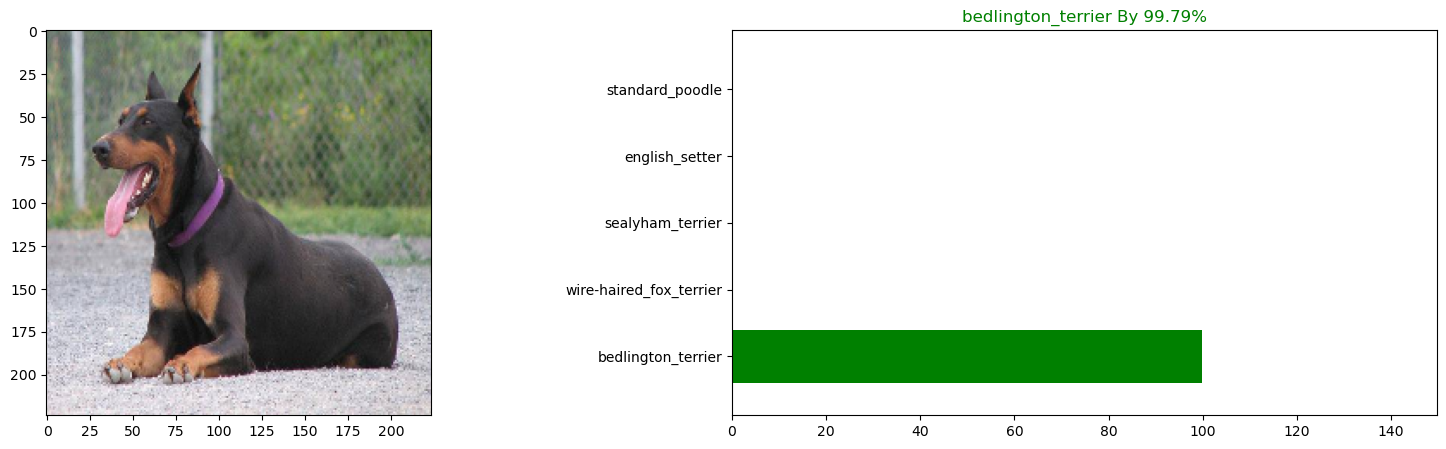

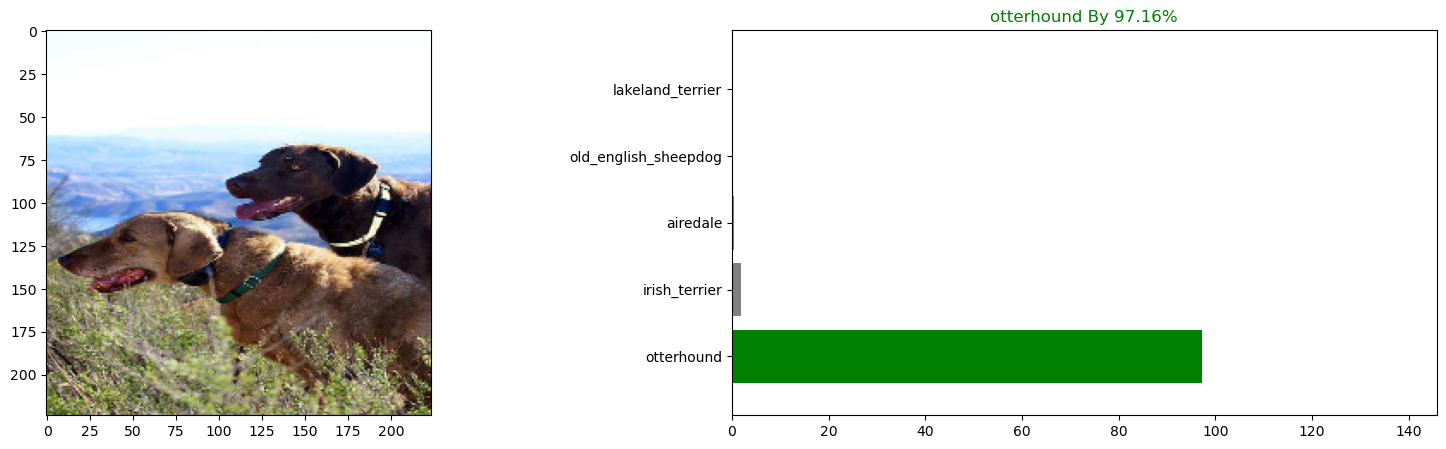

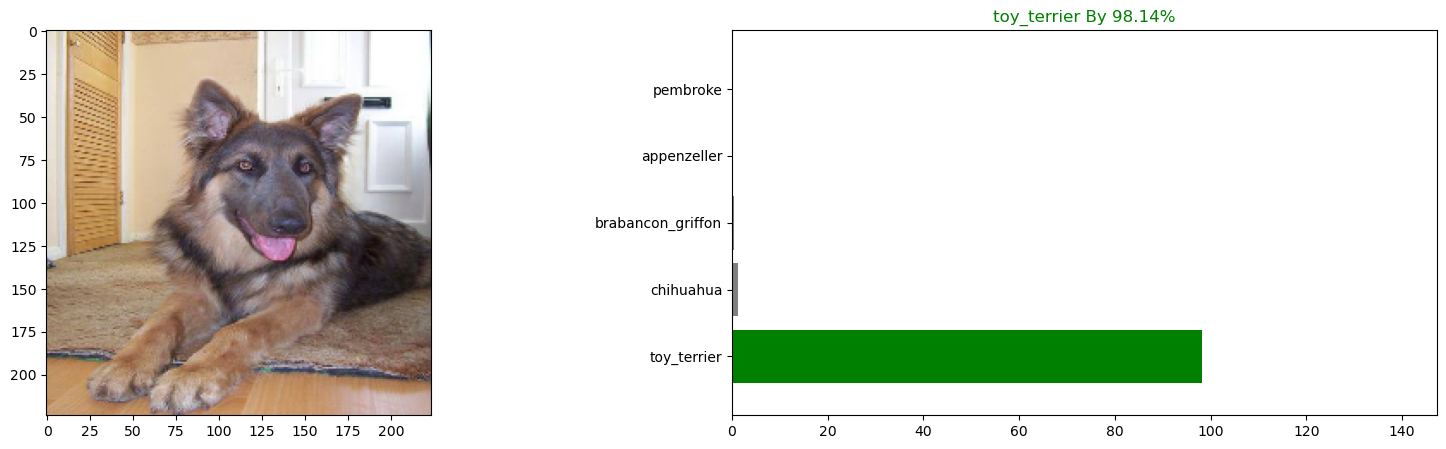

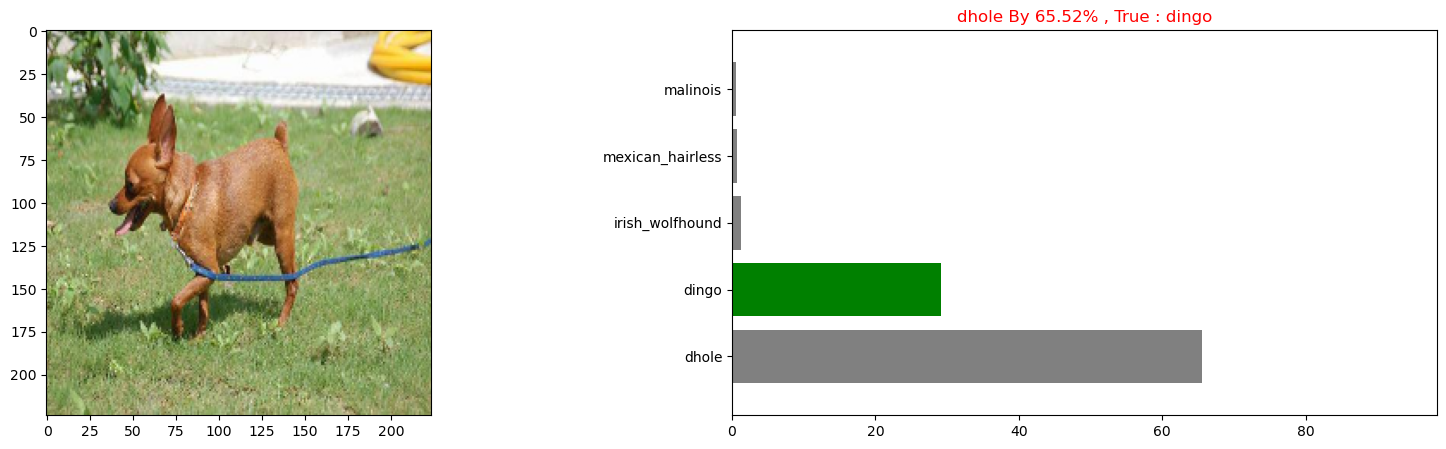

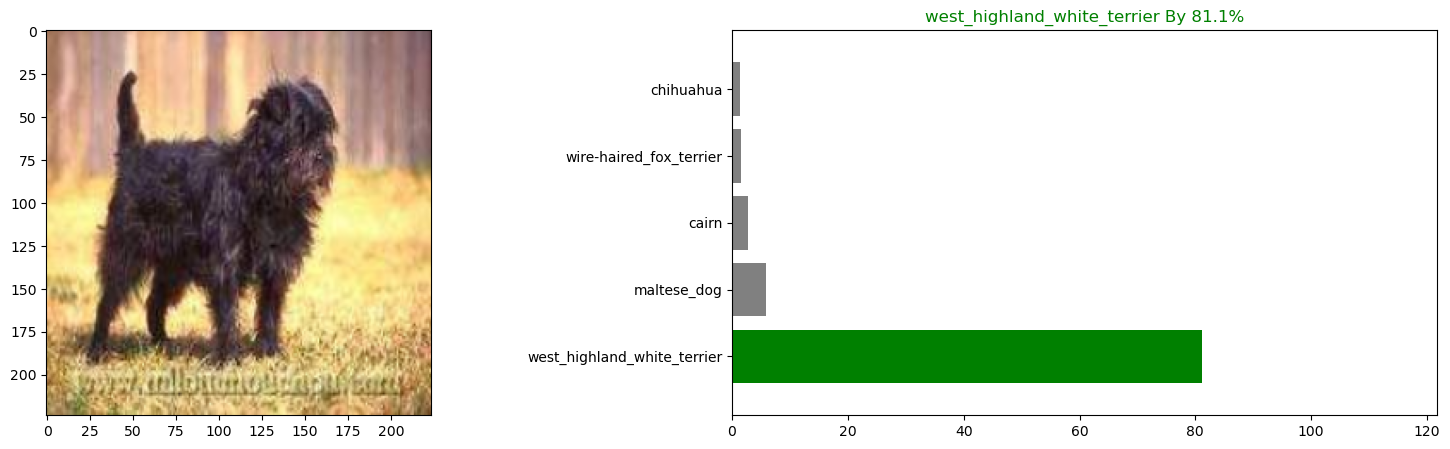

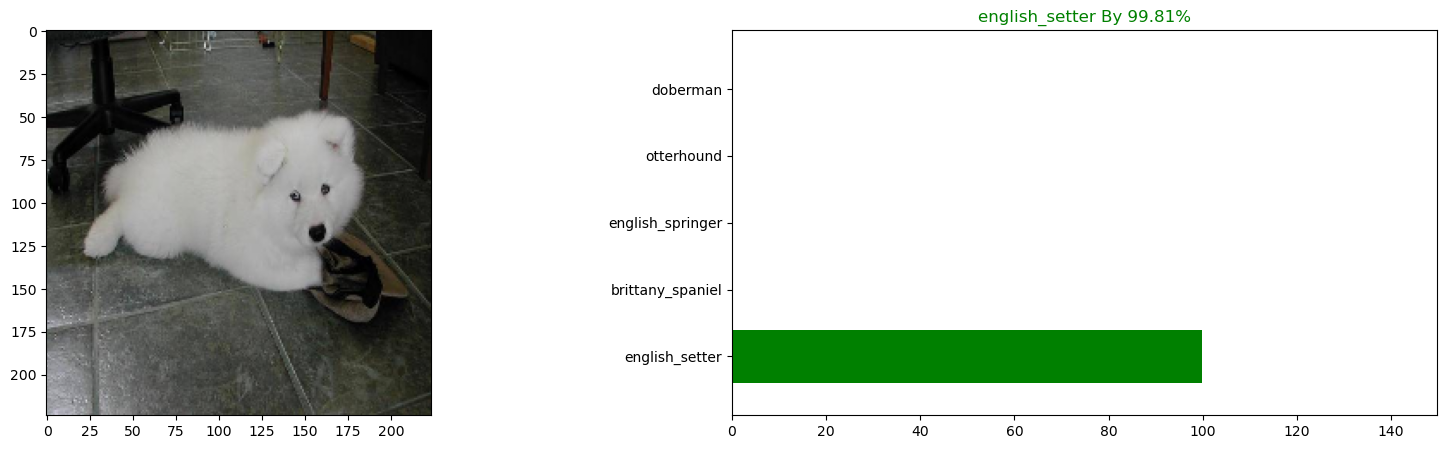

In [48]:
ev=evaluate(val=np.arange(20,len(n_xte),500),mo=n_model,X=n_xte,Y=n_yte,uni=unique)

In [40]:
n_model.evaluate(n_xte,n_yte)

80/80 [==============================] - 2s 22ms/step - loss: 0.3993 - accuracy: 0.8775


[0.3992897570133209, 0.877543032169342]